In [1]:
import pandas as pd 
import numpy as np 
import tkinter
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
data = pd.read_csv('data.csv', index_col=['Date'])  
data.head() 

,Open,High,Low,Close,Adj Close,Volume,Returns,Target
Date,,,,,,,,
2008-12-31,50.74,51.69,49.91,51.28,51.236667,7792200,0.000000,-1
2009-01-02,51.35,54.53,51.07,54.36,53.413333,7296400,0.058328,1
2009-01-05,55.73,55.74,53.03,54.06,55.176667,9509800,-0.005534,-1
2009-01-06,54.55,58.22,53.75,57.36,56.710000,11080100,0.059253,1
2009-01-07,56.29,56.95,55.35,56.20,56.480000,7942700,-0.020430,-1


In [3]:
import pickle 
model = pickle.load(open('base_model.sav', 'rb'))  
predictions = model.predict(data.iloc[:,0:7][-int(data.shape[0] * 0.15):])  

In [4]:
# Stock Indicators 
# 1. Standard Deviation 
data['Std'] = data['Adj Close'].rolling(window = 100).std() 
# 2. Simple Moving Average 
data['SMA'] = data['Adj Close'].rolling(window = 100).mean() 
data.tail(10) 

,Open,High,Low,Close,Adj Close,Volume,Returns,Target,Std,SMA
Date,,,,,,,,,,
2019-09-23,1777.00,1792.70,1767.32,1785.30,1785.000000,2922300,-0.004950,-1,74.177299,1867.730667
2019-09-24,1790.61,1795.71,1735.55,1741.61,1775.976667,4616000,-0.024776,-1,74.603870,1866.371433
2019-09-25,1747.36,1773.00,1723.00,1768.33,1762.896667,3493200,0.015226,1,74.726583,1864.414200
2019-09-26,1762.79,1763.37,1731.50,1739.84,1755.333333,3536800,-0.016242,-1,75.093981,1862.542433
2019-09-27,1748.00,1749.12,1713.82,1725.45,1740.856667,3907200,-0.008305,-1,75.691862,1860.584033
2019-09-30,1726.99,1737.46,1709.22,1735.91,1733.453333,2644700,0.006044,1,76.473647,1858.678533
2019-10-01,1746.00,1755.60,1728.41,1735.65,1745.750000,3084500,-0.000150,-1,77.166131,1857.105133
2019-10-02,1727.74,1728.89,1705.00,1713.23,1723.286667,3301100,-0.013002,-1,78.205837,1855.365433
2019-10-03,1713.00,1725.00,1685.06,1724.42,1720.806667,3468200,0.006510,1,79.332441,1854.220900


In [5]:
# 3. Bollinger Bands 
# https://www.bollingerbands.com/bollinger-bands 
data['bb_upper'] = data.SMA + (data.Std * 2) 
data['bb_lower'] = data.SMA + (data.Std * 2) 

# 4. Moving Average Convergence/Divergence 
# https://www.investopedia.com/terms/m/macd.asp 
data['MACD'] = data['Adj Close'].ewm(span = 12).mean() - data['Adj Close'].ewm(span = 26).mean() 
data['MACD_Threshold'] = data['MACD'].ewm(span = 9).mean() 
data['MACD_Crossover'] = data.MACD - data.MACD_Threshold

# 4. Relative Strength Index
def rsi_timeseries(prices, n=14):
    deltas = (prices-prices.shift(1)).fillna(0)
    avg_of_gains = deltas[1:n+1][deltas > 0].sum() / n
    avg_of_losses = -deltas[1:n+1][deltas < 0].sum() / n

    # Set up pd.Series container for RSI values
    rsi_series = pd.Series(0.0, deltas.index)

    # Now calculate RSI using the Wilder smoothing method, starting with n+1 delta.
    up = lambda x: x if x > 0 else 0
    down = lambda x: -x if x < 0 else 0
    i = n+1
    for d in deltas[n+1:]:
        avg_of_gains = ((avg_of_gains * (n-1)) + up(d)) / n
        avg_of_losses = ((avg_of_losses * (n-1)) + down(d)) / n
        if avg_of_losses != 0:
            rs = avg_of_gains / avg_of_losses
            rsi_series[i] = 100 - (100 / (1 + rs))
        else:
            rsi_series[i] = 100
        i += 1

    return rsi_series

data['RSI'] = rsi_timeseries(data['Adj Close'])  

data['Returns'].fillna(0) 
# 5. Momentem, Calculated weekly 
data['mom'] = np.sign(data['Returns'].rolling(5).mean()) 

# to avoid RunTime Error
data.replace([np.inf, -np.inf], np.nan)
data.fillna(0, inplace = True) 

data.tail(10)   

C:\Users\siddh\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Open,High,Low,Close,Adj Close,Volume,Returns,Target,Std,SMA,bb_upper,bb_lower,MACD,MACD_Threshold,MACD_Crossover,RSI,mom
Date,,,,,,,,,,,,,,,,,
2019-09-23,1777.00,1792.70,1767.32,1785.30,1785.000000,2922300,-0.004950,-1,74.177299,1867.730667,2016.085264,2016.085264,-5.613682,-6.021593,0.407911,39.230551,-1.0
2019-09-24,1790.61,1795.71,1735.55,1741.61,1775.976667,4616000,-0.024776,-1,74.603870,1866.371433,2015.579174,2015.579174,-8.342566,-6.485787,-1.856779,37.256915,-1.0
2019-09-25,1747.36,1773.00,1723.00,1768.33,1762.896667,3493200,0.015226,1,74.726583,1864.414200,2013.867366,2013.867366,-11.428928,-7.474416,-3.954512,34.543973,-1.0
2019-09-26,1762.79,1763.37,1731.50,1739.84,1755.333333,3536800,-0.016242,-1,75.093981,1862.542433,2012.730395,2012.730395,-14.320116,-8.843556,-5.476560,33.045543,-1.0
2019-09-27,1748.00,1749.12,1713.82,1725.45,1740.856667,3907200,-0.008305,-1,75.691862,1860.584033,2011.967757,2011.967757,-17.576934,-10.590231,-6.986702,30.333327,-1.0
2019-09-30,1726.99,1737.46,1709.22,1735.91,1733.453333,2644700,0.006044,1,76.473647,1858.678533,2011.625827,2011.625827,-20.518844,-12.575954,-7.942890,29.021505,-1.0
2019-10-01,1746.00,1755.60,1728.41,1735.65,1745.750000,3084500,-0.000150,-1,77.166131,1857.105133,2011.437395,2011.437395,-21.608995,-14.382562,-7.226433,34.117942,-1.0
2019-10-02,1727.74,1728.89,1705.00,1713.23,1723.286667,3301100,-0.013002,-1,78.205837,1855.365433,2011.777108,2011.777108,-24.008793,-16.307808,-7.700985,29.895044,-1.0
2019-10-03,1713.00,1725.00,1685.06,1724.42,1720.806667,3468200,0.006510,1,79.332441,1854.220900,2012.885782,2012.885782,-25.813207,-18.208888,-7.604319,29.461489,-1.0


In [6]:
close = data['Adj Close'][-predictions.shape[0]:]  
sma = data['SMA'][-predictions.shape[0]:] 
mom = data['mom'][-predictions.shape[0]:] 
rsi = data['RSI'][-predictions.shape[0]:] 
macd = data['MACD_Crossover'][-predictions.shape[0]:] 
bb_upper = data['bb_upper'][-predictions.shape[0]:]
bb_lower = data['bb_lower'][-predictions.shape[0]:]  

# Buying indicators
buy1 = close > sma
buy2 = mom > 0
buy3 = rsi < 55
buy4 = macd > 0 
BUY = buy1 | buy2 | buy3 | buy4   

# selling indicators
sell1 = close < sma
sell2 = mom < 0 
sell3 = rsi > 50
sell4 = macd < 0 
SELL = sell1 | sell2 | sell3 | sell4 

# filtering based on Stock indicators
filter1 = BUY > 0 
filter2 = SELL > 0  

In [7]:
kpi = pd.DataFrame({'Pred':predictions, 'Buy':BUY, 'Sell': SELL, 'Filter1':filter1, 'Filter2':filter2})  
kpi['Signal'] = np.where(kpi['Filter1'], 1, 0)
kpi['Signal'] = np.where(kpi['Filter2'], -1, kpi['Signal'])  

In [8]:
df = data[-int(data.shape[0] * 0.15):]  

In [9]:
buys = kpi.loc[kpi['Signal'] == 1]
sells = kpi.loc[kpi['Signal'] == -1] 

In [10]:
real_stock_price = df.iloc[:,4] 
real_stock_price = real_stock_price.values
real_stock_price = pd.DataFrame(real_stock_price)  # convert to pandas data frame 

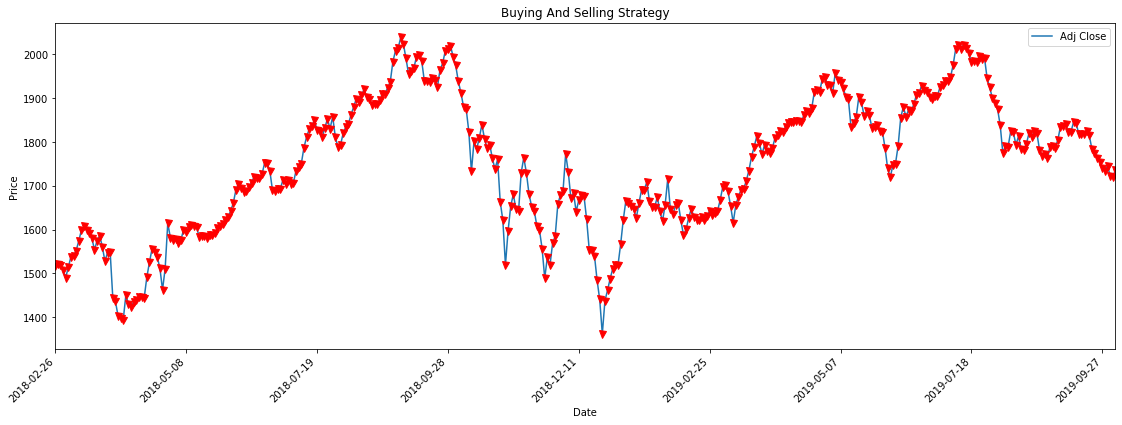

In [11]:
df['Adj Close'].plot(figsize=(19, 6))   
plt.plot(df.loc[sells.index]['Adj Close'], 'v', markersize=7, color='r')
plt.plot(df.loc[buys.index]['Adj Close'], '^', markersize=7, color='g')
plt.ylabel('Price') 
plt.xlabel('Date')
plt.legend(loc=0)  
plt.title('Buying And Selling Strategy')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()  

__Backtesting__

In [12]:
def backtest(data) : 
    investment = 100000 
    initial = 0 
    total = 0 
    equity = list() 
    data['Total'] = 100000 
    stock = 10 # for buying 10 stocks at a time 
    
    for row in data.iterrows() : 
        price = float(row[1][0])
        signal = kpi.iloc[row[0]][1] 
        # BUYING
        if(signal > 0 and investment - stock * price > 0 ) : 
            investment = investment - stock * price 
            initial = initial + stock 
        elif(signal < 0 and abs(initial * price) < investment) : 
            investment = investment + stock * price 
            initial = initial - stock 
        equity.append(float(initial * price + investment)) 
    equity_data = pd.DataFrame(equity, columns = ['Total']) 
    return equity_data

In [13]:
equity_data = backtest(real_stock_price) 
equity_data.index = pd.to_datetime(kpi.index)   

In [14]:
import ffn
perf = equity_data.Total.calc_stats() 

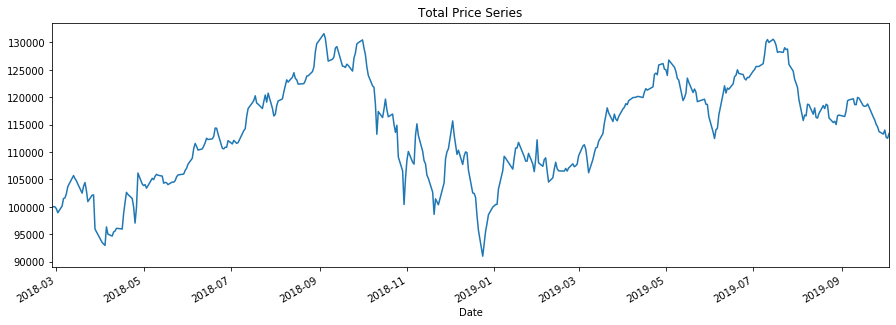

In [15]:
perf.plot(); 

In [16]:
perf.return_table.T

,2018,2019
Jan,0.000000,0.122957
Feb,0.000136,-0.039406
Mar,-0.045603,0.080387
Apr,0.091317,0.074200
May,0.027453,-0.068998
Jun,0.047200,0.060950
Jul,0.040248,-0.008290
Aug,0.116017,-0.047472
Sep,-0.001254,-0.029664
Oct,-0.191146,0.001040


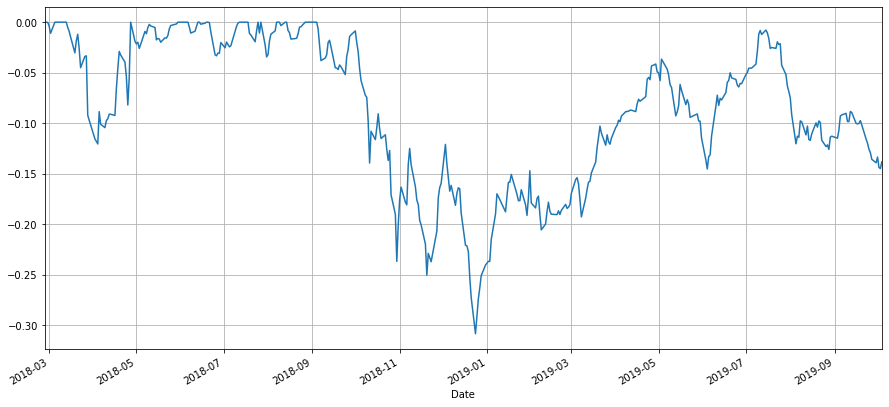

In [17]:
ffn.to_drawdown_series(equity_data['Total']).plot(figsize=(15, 7), grid=True); 

In [18]:
perf.display() 

Stats for Total from 2018-02-26 00:00:00 - 2019-10-04 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
13.40%              0.45  8.17%   -30.86%

Annualized Returns:
mtd    3m      6m      ytd     1y      3y     5y    10y    incep.
-----  ------  ------  ------  ------  -----  ----  -----  --------
0.10%  -9.72%  -4.42%  13.46%  -9.69%  8.17%  -     -      8.17%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.45     0.41       -
mean    10.67%   11.15%     13.46%
vol     23.87%   27.02%     -
skew    -0.15    -0.75      -
kurt    2.75     0.76       -
best    6.25%    12.30%     13.46%
worst   -6.09%   -19.11%    13.46%

Drawdowns:
max      avg       # days
-------  ------  --------
-30.86%  -4.97%      44.5

Misc:
---------------  -------
avg. up month    6.49%
avg. down month  -5.87%
up year %        100.00%
12m up %         80.00%
----

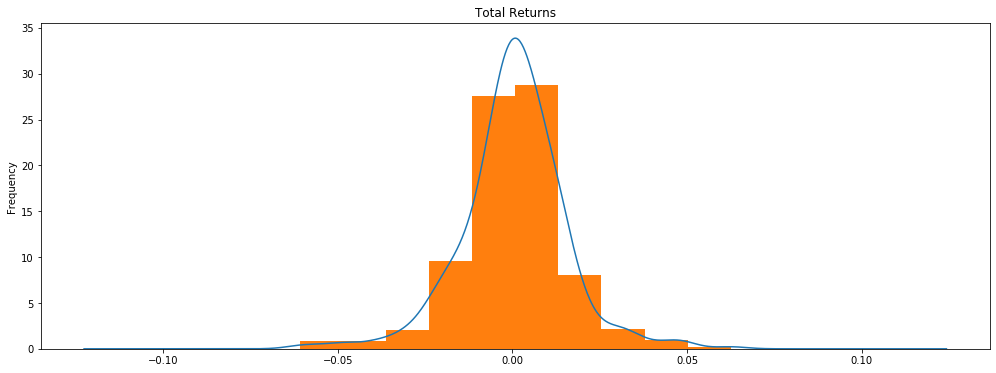

In [19]:
fig, ax = plt.subplots(figsize = (17, 6))
perf.returns.plot.kde(title = 'Total Returns');  
perf.returns.plot.hist(density = True);  